Online Convolutional Dictionary Learning with Spatial Mask
==========================================================

This example demonstrates the use of [dictlrn.onlinecdl.OnlineConvBPDNMaskDictLearn](http://sporco.rtfd.org/en/latest/modules/sporco.dictlrn.onlinecdl.html#sporco.dictlrn.onlinecdl.OnlineConvBPDNMaskDictLearn) for learning a convolutional dictionary from a set of training images. The dictionary is learned using the online dictionary learning algorithm proposed in [[33]](http://sporco.rtfd.org/en/latest/zreferences.html#liu-2018-first).

In [1]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.dictlrn import onlinecdl
from sporco import util
from sporco import signal
from sporco import cuda
from sporco import plot
plot.config_notebook_plotting()

Load training images.

In [2]:
exim = util.ExampleImages(scaled=True, zoom=0.5, gray=True)
S1 = exim.image('barbara.png', idxexp=np.s_[10:522, 100:612])
S2 = exim.image('kodim23.png', idxexp=np.s_[:, 60:572])
S3 = exim.image('monarch.png', idxexp=np.s_[:, 160:672])
S4 = exim.image('sail.png', idxexp=np.s_[:, 210:722])
S5 = exim.image('tulips.png', idxexp=np.s_[:, 30:542])
S = np.dstack((S1, S2, S3, S4, S5))

Highpass filter training images.

In [3]:
npd = 16
fltlmbd = 5
sl, sh = signal.tikhonov_filter(S, fltlmbd, npd)

Create random mask and apply to highpass filtered training image set.

In [4]:
np.random.seed(12345)
frc = 0.25
W = signal.rndmask(S.shape, frc, dtype=np.float32)
shw = W * sh

Construct initial dictionary.

In [5]:
D0 = np.random.randn(8, 8, 32)

Set regularization parameter and options for dictionary learning solver.

In [6]:
lmbda = 0.1
opt = onlinecdl.OnlineConvBPDNMaskDictLearn.Options({
                'Verbose': True, 'ZeroMean': False, 'eta_a': 10.0,
                'eta_b': 20.0, 'DataType': np.float32,
                'CBPDN': {'rho': 3.0, 'AutoRho': {'Enabled': False},
                    'RelaxParam': 1.8, 'RelStopTol': 1e-4, 'MaxMainIter': 100,
                    'FastSolve': False, 'DataType': np.float32}})
if cuda.device_count() > 0:
    opt['CUDA_CBPDN'] = True

Create solver object and solve.

In [7]:
d = onlinecdl.OnlineConvBPDNMaskDictLearn(D0, lmbda, opt)

iter = 50
d.display_start()
for it in range(iter):
    img_index = np.random.randint(0, sh.shape[-1])
    d.solve(shw[..., [img_index]], W[..., [img_index]])

d.display_end()
D1 = d.getdict()
print("OnlineConvBPDNMaskDictLearn solve time: %.2fs" %
      d.timer.elapsed('solve'))

Itn   X r       X s       X ρ       D cnstr   D dlt     D η     
----------------------------------------------------------------


   0  0.00e+00  0.00e+00  0.00e+00  3.58e+01  2.12e+00  5.00e-01
   1  0.00e+00  0.00e+00  0.00e+00  2.82e+01  1.48e+00  4.76e-01


   2  0.00e+00  0.00e+00  0.00e+00  2.52e+01  9.82e-01  4.55e-01
   3  0.00e+00  0.00e+00  0.00e+00  2.39e+01  6.81e-01  4.35e-01


   4  0.00e+00  0.00e+00  0.00e+00  1.10e+01  7.68e-01  4.17e-01
   5  0.00e+00  0.00e+00  0.00e+00  2.45e+01  9.28e-01  4.00e-01


   6  0.00e+00  0.00e+00  0.00e+00  2.29e+01  1.44e+00  3.85e-01
   7  0.00e+00  0.00e+00  0.00e+00  9.67e+00  6.27e-01  3.70e-01


   8  0.00e+00  0.00e+00  0.00e+00  1.95e+01  5.49e-01  3.57e-01
   9  0.00e+00  0.00e+00  0.00e+00  1.89e+01  3.76e-01  3.45e-01


  10  0.00e+00  0.00e+00  0.00e+00  8.65e+00  4.74e-01  3.33e-01
  11  0.00e+00  0.00e+00  0.00e+00  1.97e+01  7.32e-01  3.23e-01


  12  0.00e+00  0.00e+00  0.00e+00  1.70e+01  4.52e-01  3.12e-01
  13  0.00e+00  0.00e+00  0.00e+00  2.02e+01  7.10e-01  3.03e-01


  14  0.00e+00  0.00e+00  0.00e+00  1.94e+01  4.86e-01  2.94e-01
  15  0.00e+00  0.00e+00  0.00e+00  1.89e+01  3.88e-01  2.86e-01


  16  0.00e+00  0.00e+00  0.00e+00  1.84e+01  3.19e-01  2.78e-01
  17  0.00e+00  0.00e+00  0.00e+00  1.44e+01  6.04e-01  2.70e-01


  18  0.00e+00  0.00e+00  0.00e+00  1.54e+01  6.15e-01  2.63e-01
  19  0.00e+00  0.00e+00  0.00e+00  1.49e+01  1.00e+00  2.56e-01


  20  0.00e+00  0.00e+00  0.00e+00  1.68e+01  5.41e-01  2.50e-01
  21  0.00e+00  0.00e+00  0.00e+00  1.44e+01  5.49e-01  2.44e-01


  22  0.00e+00  0.00e+00  0.00e+00  1.40e+01  3.85e-01  2.38e-01
  23  0.00e+00  0.00e+00  0.00e+00  1.37e+01  3.21e-01  2.33e-01


  24  0.00e+00  0.00e+00  0.00e+00  5.79e+00  4.06e-01  2.27e-01
  25  0.00e+00  0.00e+00  0.00e+00  1.17e+01  4.26e-01  2.22e-01


  26  0.00e+00  0.00e+00  0.00e+00  1.45e+01  4.68e-01  2.17e-01
  27  0.00e+00  0.00e+00  0.00e+00  1.20e+01  8.06e-01  2.13e-01


  28  0.00e+00  0.00e+00  0.00e+00  1.10e+01  3.56e-01  2.08e-01
  29  0.00e+00  0.00e+00  0.00e+00  1.12e+01  5.25e-01  2.04e-01


  30  0.00e+00  0.00e+00  0.00e+00  1.06e+01  3.13e-01  2.00e-01
  31  0.00e+00  0.00e+00  0.00e+00  4.95e+00  3.17e-01  1.96e-01


  32  0.00e+00  0.00e+00  0.00e+00  1.14e+01  4.91e-01  1.92e-01
  33  0.00e+00  0.00e+00  0.00e+00  4.83e+00  2.83e-01  1.89e-01


  34  0.00e+00  0.00e+00  0.00e+00  4.76e+00  2.34e-01  1.85e-01
  35  0.00e+00  0.00e+00  0.00e+00  1.00e+01  4.77e-01  1.82e-01


  36  0.00e+00  0.00e+00  0.00e+00  4.61e+00  2.16e-01  1.79e-01
  37  0.00e+00  0.00e+00  0.00e+00  4.55e+00  1.90e-01  1.75e-01


  38  0.00e+00  0.00e+00  0.00e+00  1.03e+01  4.70e-01  1.72e-01
  39  0.00e+00  0.00e+00  0.00e+00  4.44e+00  2.09e-01  1.69e-01


  40  0.00e+00  0.00e+00  0.00e+00  9.97e+00  3.55e-01  1.67e-01
  41  0.00e+00  0.00e+00  0.00e+00  1.09e+01  3.94e-01  1.64e-01


  42  0.00e+00  0.00e+00  0.00e+00  8.92e+00  4.62e-01  1.61e-01
  43  0.00e+00  0.00e+00  0.00e+00  1.06e+01  3.34e-01  1.59e-01


  44  0.00e+00  0.00e+00  0.00e+00  1.04e+01  2.74e-01  1.56e-01
  45  0.00e+00  0.00e+00  0.00e+00  9.12e+00  4.01e-01  1.54e-01


  46  0.00e+00  0.00e+00  0.00e+00  7.94e+00  3.17e-01  1.52e-01
  47  0.00e+00  0.00e+00  0.00e+00  7.89e+00  2.45e-01  1.49e-01


  48  0.00e+00  0.00e+00  0.00e+00  8.73e+00  3.32e-01  1.47e-01
  49  0.00e+00  0.00e+00  0.00e+00  7.68e+00  2.40e-01  1.45e-01
----------------------------------------------------------------
OnlineConvBPDNMaskDictLearn solve time: 12.34s


Display initial and final dictionaries.

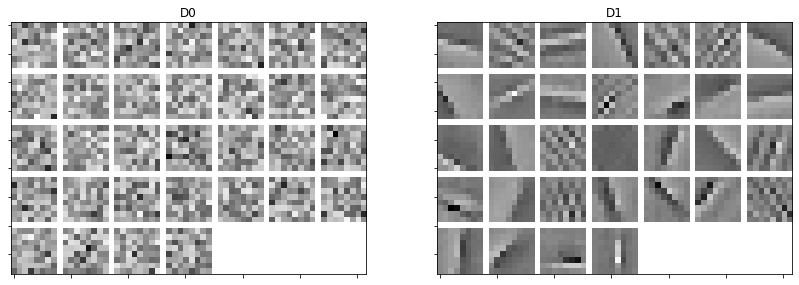

In [8]:
D1 = D1.squeeze()
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0), title='D0', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1), title='D1', fig=fig)
fig.show()

Get iterations statistics from solver object and plot functional value.

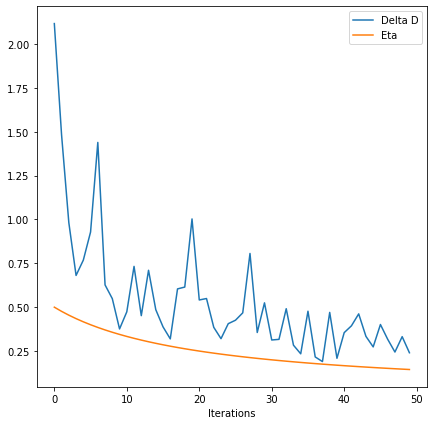

In [9]:
its = d.getitstat()
fig = plot.figure(figsize=(7, 7))
plot.plot(np.vstack((its.DeltaD, its.Eta)).T, xlbl='Iterations',
          lgnd=('Delta D', 'Eta'), fig=fig)
fig.show()